In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import olympus
from olympus.datasets import Dataset
from olympus.emulators import Emulator
from olympus.campaigns import Campaign 
from olympus.scalarizers import Scalarizer
from olympus.plotter import Plotter

In [135]:
# helper functions


def get_single_traces(campaigns):
    traces = []
    for campaign in campaigns:
        trace = campaign.best_values
        assert trace.shape[1]==1
        traces.append(trace)
    return np.array(traces).squeeze(axis=-1)
    

def get_traces(campaigns, scalarizer):
    traces = []
    for campaign in campaigns:
#         print(campaign.observations.get_values().shape)
        values = campaign.observations.get_values()
        scalarized = scalarizer.scalarize(values)
        trace_best_idx = [np.argmin(scalarized[:i+1]) for i in range(len(scalarized))]
        #instance_trace = []
        trace0 = values[trace_best_idx, 0]
        trace1 = values[trace_best_idx, 1]
        trace2 = values[trace_best_idx, 2]
        traces.append([trace0, trace1, trace2])
    return np.array(traces)


def get_frac_top_k(campaigns, dataset, scalarizer, k):
    ''' returns the fraction of tolerable candidates measuremd at each iteration
    '''
    traces = []
    
    values = dataset.targets.values
    scalarized = scalarizer.scalarize(values)
    sort_idxs = np.argsort(scalarized, axis=0)
    sort_values = [values[i] for i in sort_idxs]
    
    for campaign in campaigns:
        campaign_trace = []
        campaign_values = campaign.observations.get_values()
        for val_ix in range(len(campaign_values)):
            campaign_trace.append(
                sum(val in campaign_values[:val_ix] for val in sort_values)/ len(sort_values)
            )
        traces.append(campaign_trace)
        
    return np.array(traces)
    


def plot_trace_mean(traces, obj_num=0, ax=None, color=None, label=None, use_std_err=True):

    if obj_num==None:
        pass
    elif isinstance(obj_num, int):
        traces = traces[:, obj_num, :]
        
    if ax is None:
        fig, ax = plt.subplots()
    mean = np.mean(traces, axis=0)
    if use_std_err is True:
        stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
    else:
        stde = np.nanstd(traces, axis=0, ddof=1)

    x = np.arange(1, len(mean) + 1, 1)
        
    ax.plot(x, mean, color='#444444', linewidth=5, zorder=11)
    ax.plot(x, mean, color=color, linewidth=4, label=label, zorder=11)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color, zorder=10)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)


def plot_trace_sigle(pkl_file, ax, obj_name, goal='min', color='k', label='', shift=0.0, use_std_err=True):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    plot_trace_mean(data, obj_name, goal=goal, ax=ax, color=color, label=label, shift=shift, use_std_err=use_std_err)
    

def gradient_patch(ax, xmin, xmax, ymin, ymax, fill_color='k', alpha=1, zorder=1):
    
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    
    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Rectangle(xy=(xmin, ymin), width=xmax-xmin, height=ymax-ymin, 
                          facecolor='none', edgecolor='none')
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

## Case study 1 - compre performance metrics

dye_lasers, redoxmers

### Plots to make

* multi-objective traces (make general purpose function)

* fraction of tolerable candidates found

In [169]:
#------------
# DYE LASERS
#------------
case_study = 'case_study_1'
dataset = 'dye_lasers'

# load results

with open(f'{case_study}/RandomSearch/{dataset}/results.pkl', 'rb') as content:
    data_random = pickle.load(content)
    
# with open(f'{case_study}/Genetic/{dataset}/results.pkl', 'rb') as content:
#     data_genetic = pickle.load(content)
    
# with open(f'{case_study}/Hyperopt/{dataset}/results.pkl', 'rb') as content:
#     data_hyperopt = pickle.load(content)
    
with open(f'{case_study}/Gpyopt/{dataset}/results.pkl', 'rb') as content:
    data_gpyopt = pickle.load(content)
    
# with open(f'{case_study}/Gryffin/{dataset}/results.pkl', 'rb') as content:
#     data_gryffin = pickle.load(content)

with open(f'{case_study}/Dragonfly/{dataset}/results.pkl', 'rb') as content:
    data_dragonfly = pickle.load(content)
    
with open(f'{case_study}/Botorch/{dataset}/results.pkl', 'rb') as content:
    data_botorch = pickle.load(content)
    
# with open(f'{case_study}/Smac/{dataset}/results.pkl', 'rb') as content:
#     data_smac = pickle.load(content)
    
with open(f'{case_study}/Hebo/{dataset}/results.pkl', 'rb') as content:
    data_hebo = pickle.load(content)
    
    
print('NUM RANDOM :', len(data_random))
#print('NUM GENETIC :', len(data_genetic))
#print('NUM HYPEROPT :', len(data_hyperopt))
print('NUM GPYOPT :', len(data_gpyopt))
#print('NUM GRYFFIN :', len(data_gryffin))
print('NUM DRAGONFLY :', len(data_dragonfly))
print('NUM BOTORCH :', len(data_botorch))
print('NUM HEBO :', len(data_hebo))

NUM RANDOM : 40
NUM GPYOPT : 27
NUM DRAGONFLY : 40
NUM BOTORCH : 40
NUM HEBO : 35


In [170]:
scalarizer = Scalarizer(
        kind='Chimera', 
        value_space=Dataset(kind='dye_lasers').value_space,
        goals=['max', 'min', 'max'],
        tolerances=[0.7, 0.2, 0.2],
        absolutes=[True, True, True]
    )

traces_random = get_traces(data_random, scalarizer)
#traces_genetic = get_traces(data_genetic, scalarizer)
#traces_hyperopt = get_traces(data_hyperopt, scalarizer)
traces_gpyopt = get_traces(data_gpyopt, scalarizer)
#traces_gryffin = get_traces(data_gryffin, scalarizer)
traces_dragonfly = get_traces(data_dragonfly, scalarizer)
traces_botorch = get_traces(data_botorch, scalarizer)
traces_hebo = get_traces(data_hebo, scalarizer)

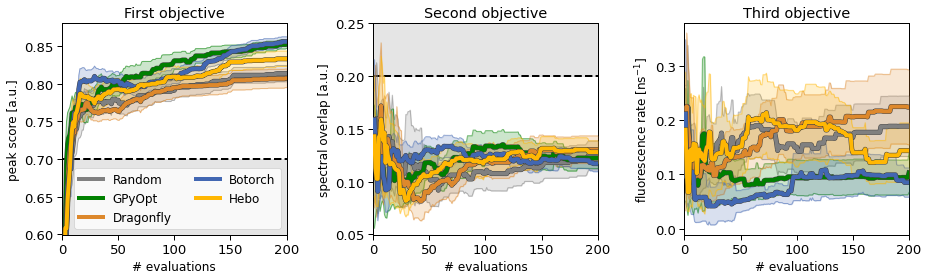

In [138]:
# MOO trace plot

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13,4), sharex=True)

axes[0].set_title('First objective')
axes[1].set_title('Second objective')
axes[2].set_title('Third objective')

for i in range(3):
    plot_trace_mean(traces_random, obj_num=i, ax=axes[i], color='gray', label='Random')
    plot_trace_mean(traces_gpyopt, obj_num=i, ax=axes[i], color='g', label='GPyOpt')
    plot_trace_mean(traces_dragonfly, obj_num=i, ax=axes[i], color='#dd882c', label='Dragonfly')
    plot_trace_mean(traces_botorch, obj_num=i, ax=axes[i], color='#4267B2', label='Botorch')
    plot_trace_mean(traces_hebo, obj_num=i, ax=axes[i], color='#ffb703', label='Hebo')
    
    
axes[0].set_xlim(0., 200.)
axes[0].set_ylim(0.6, 0.88)
axes[0].fill_between(x=[0, 200], y1=scalarizer.tolerances[0], y2=0., alpha=0.2, color='gray')
axes[0].axhline(y=scalarizer.tolerances[0], linestyle='--', linewidth=2, color='k', zorder=2)
axes[0].legend(loc='lower right', ncol=2, fontsize=12)
axes[0].set_xlabel('# evaluations', fontsize=12)
axes[0].set_ylabel('peak score [a.u.]', fontsize=12)

axes[1].set_xlim(0., 200.)
axes[1].set_ylim(0.050, 0.25)
axes[1].fill_between(x=[0, 200], y1=scalarizer.tolerances[1], y2=0.25, alpha=0.2, color='gray')
axes[1].axhline(y=scalarizer.tolerances[1], linestyle='--', linewidth=2, color='k', zorder=2)
axes[1].set_ylabel('spectral overlap [a.u.]', fontsize=12)

axes[1].set_xlabel('# evaluations', fontsize=12)

axes[2].set_xlim(0., 200.)
axes[2].set_xlabel('# evaluations', fontsize=12)
axes[2].set_ylabel('fluorescence rate [ns$^{-1}$]', fontsize=12)



plt.tight_layout()
plt.savefig('cs1_dye_lasers_traces.png', dpi=300)

In [143]:
dataset = Dataset(kind='dye_lasers')
dataset.target_names

['peak_score', 'spectral_overlap', 'fluo_rate']

In [140]:
top_k_traces_random = get_frac_top_k(data_random, dataset, scalarizer, 20)

KeyboardInterrupt: 

## Case study 2 (Suzuki)

## Case study 2 (buchwald)

see if trends carry between related datasets

### Plots to make 

* traces
* regret after x iterations
* best candidate rank after x

In [171]:
case_study = 'case_study_2_buchwald'

# load results

data_random = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    with open(f'{case_study}/RandomSearch/buchwald_{sub}/results.pkl', 'rb') as content:
        data_random_ = pickle.load(content)
        data_random[sub] = data_random_
        
data_gpyopt = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    with open(f'{case_study}/Gpyopt/buchwald_{sub}/results.pkl', 'rb') as content:
        data_gpyopt_ = pickle.load(content)
        data_gpyopt[sub] = data_gpyopt_
        
data_dragonfly = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    with open(f'{case_study}/Dragonfly/buchwald_{sub}/results.pkl', 'rb') as content:
        data_dragonfly_ = pickle.load(content)
        data_dragonfly[sub] = data_dragonfly_
        
data_botorch = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    with open(f'{case_study}/Botorch/buchwald_{sub}/results.pkl', 'rb') as content:
        data_botorch_ = pickle.load(content)
        data_botorch[sub] = data_botorch_
        
data_hebo = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    with open(f'{case_study}/Hebo/buchwald_{sub}/results.pkl', 'rb') as content:
        data_hebo_ = pickle.load(content)
        data_hebo[sub] = data_hebo_
        
    
# print('NUM RANDOM :', len(data_random))
# #print('NUM GENETIC :', len(data_genetic))
# #print('NUM HYPEROPT :', len(data_hyperopt))
# print('NUM GPYOPT :', len(data_gpyopt))
# #print('NUM GRYFFIN :', len(data_gryffin))
# print('NUM DRAGONFLY :', len(data_dragonfly))
# print('NUM BOTORCH :', len(data_botorch))
# print('NUM HEBO :', len(data_hebo))

In [172]:
# get traces
traces_random = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    traces_random[sub]= get_single_traces(data_random[sub])
    
traces_gpyopt = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    traces_gpyopt[sub]= get_single_traces(data_gpyopt[sub])
    
traces_dragonfly = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    traces_dragonfly[sub]= get_single_traces(data_dragonfly[sub])
    
traces_botorch = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    traces_botorch[sub]= get_single_traces(data_botorch[sub])
    
traces_hebo = {}
for sub in ['a', 'b', 'c', 'd', 'e']:
    traces_hebo[sub]= get_single_traces(data_hebo[sub])

0 a
1 b
2 c
3 d
4 e


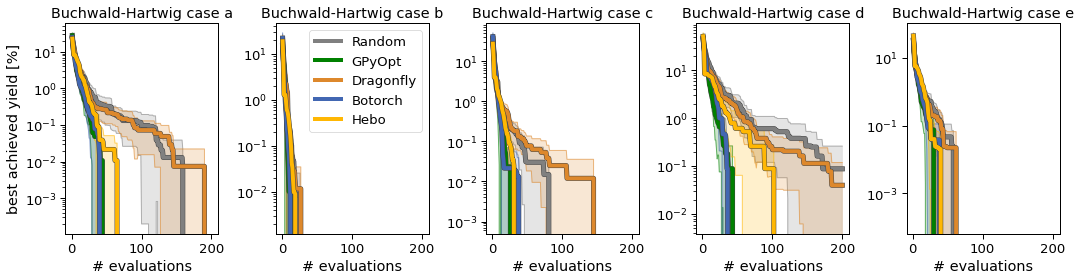

In [173]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4), sharex=True)

for i, sub in zip(range(5), ['a', 'b', 'c', 'd', 'e']):
    print(i, sub)
    
    plot_trace_mean(traces_random[sub], obj_num=None, ax=axes[i], color='gray', label='Random')
    plot_trace_mean(traces_gpyopt[sub], obj_num=None, ax=axes[i], color='g', label='GPyOpt')
    plot_trace_mean(traces_dragonfly[sub], obj_num=None, ax=axes[i], color='#dd882c', label='Dragonfly')
    plot_trace_mean(traces_botorch[sub], obj_num=None, ax=axes[i], color='#4267B2', label='Botorch')
    plot_trace_mean(traces_hebo[sub], obj_num=None, ax=axes[i], color='#ffb703', label='Hebo')
        
    axes[i].set_yscale('log')
    axes[i].set_xlabel('# evaluations')
    
    axes[i].set_title(f'Buchwald-Hartwig case {sub}')
    
axes[1].legend(loc='upper right')

axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()
plt.savefig('cs2_buchwald_trace_plots.png', dpi=300)

## Case study 3 

comparison of ASF

### plots to make

* traces

In [175]:
case_study = 'case_study_3'

# load results

data_random = {}
for sub in ['Chimera', 'WeightedSum', 'Parego']:
    with open(f'{case_study}/RandomSearch/{sub}/results.pkl', 'rb') as content:
        data_random_ = pickle.load(content)
        data_random[sub] = data_random_
        
data_gpyopt = {}
for sub in ['Chimera', 'WeightedSum', 'Parego']:
    with open(f'{case_study}/Gpyopt/{sub}/results.pkl', 'rb') as content:
        data_gpyopt_ = pickle.load(content)
        data_gpyopt[sub] = data_gpyopt_
    
        
data_botorch = {}
for sub in ['Chimera', 'WeightedSum', 'Parego']:
    with open(f'{case_study}/Botorch/{sub}/results.pkl', 'rb') as content:
        data_botorch_ = pickle.load(content)
        data_botorch[sub] = data_botorch_
        
data_hebo = {}
for sub in ['Chimera', 'WeightedSum', 'Parego']:
    with open(f'{case_study}/Hebo/{sub}/results.pkl', 'rb') as content:
        data_hebo_ = pickle.load(content)
        data_hebo[sub] = data_hebo_

In [178]:
scalarizers = {'Chimera' : Scalarizer(
                            kind='Chimera', 
                            value_space=Dataset(kind='dye_lasers').value_space,
                            goals=['max', 'min', 'max'],
                            tolerances=[0.7, 0.2, 0.2],
                            absolutes=[True, True, True]
                        ),
               'WeightedSum':
                   Scalarizer(
                            kind='WeightedSum', 
                            value_space=Dataset(kind='dye_lasers').value_space,
                            goals=['max', 'min', 'max'],
                            weights=[3, 2, 1],
                            
                        ),
                'Parego':
                   Scalarizer(
                            kind='Parego', 
                            value_space=Dataset(kind='dye_lasers').value_space,
                            goals=['max', 'min', 'max'],
                            rho=0.05
                        ),
              }


# get traces
traces_random = {}
for sub in ['Chimera', 'WeightedSum', 'Parego']:
    traces_random[sub]= get_traces(data_random[sub], scalarizers[sub])
    
traces_gpyopt = {}
for sub in ['Chimera', 'WeightedSum', 'Parego']:
    traces_gpyopt[sub]= get_traces(data_gpyopt[sub], scalarizers[sub])

traces_botorch = {}
for sub in ['Chimera', 'WeightedSum', 'Parego']:
    traces_botorch[sub]= get_traces(data_botorch[sub], scalarizers[sub])
    
traces_hebo = {}
for sub in ['Chimera', 'WeightedSum', 'Parego']:
    traces_hebo[sub]= get_traces(data_hebo[sub], scalarizers[sub])

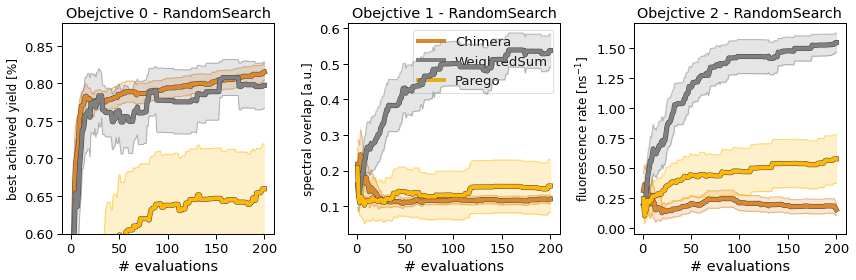

In [179]:
#---------------
# RANDOM SEARCH
#---------------

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True)

for i in range(3):
    
    plot_trace_mean(traces_random['Chimera'], obj_num=i, ax=axes[i], color='#dd882c', label='Chimera')
    plot_trace_mean(traces_random['WeightedSum'], obj_num=i, ax=axes[i], color='gray', label='WeightedSum')
    plot_trace_mean(traces_random['Parego'], obj_num=i, ax=axes[i], color='#ffb703', label='Parego')

        
    #axes[i].set_yscale('log')
    axes[i].set_xlabel('# evaluations')
    axes[i].set_title(f'Obejctive {i} - RandomSearch')

    
axes[1].legend(loc='upper right')

axes[0].set_ylim(0.6, 0.88)
axes[0].set_ylabel('peak score [a.u.]', fontsize=12)
axes[1].set_ylabel('spectral overlap [a.u.]', fontsize=12)
axes[2].set_ylabel('fluorescence rate [ns$^{-1}$]', fontsize=12)


axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()
# plt.savefig('cs2_buchwald_trace_plots.png', dpi=300)

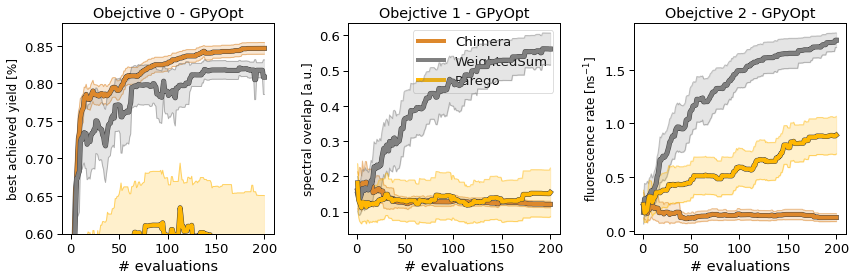

In [180]:
#---------------
# GPYOPT
#---------------

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True)

for i in range(3):
    
    plot_trace_mean(traces_gpyopt['Chimera'], obj_num=i, ax=axes[i], color='#dd882c', label='Chimera')
    plot_trace_mean(traces_gpyopt['WeightedSum'], obj_num=i, ax=axes[i], color='gray', label='WeightedSum')
    plot_trace_mean(traces_gpyopt['Parego'], obj_num=i, ax=axes[i], color='#ffb703', label='Parego')

        
    #axes[i].set_yscale('log')
    axes[i].set_xlabel('# evaluations')
    axes[i].set_title(f'Obejctive {i} - GPyOpt')

    
axes[1].legend(loc='upper right')

axes[0].set_ylim(0.6, 0.88)
axes[0].set_ylabel('peak score [a.u.]', fontsize=12)
axes[1].set_ylabel('spectral overlap [a.u.]', fontsize=12)
axes[2].set_ylabel('fluorescence rate [ns$^{-1}$]', fontsize=12)


axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()

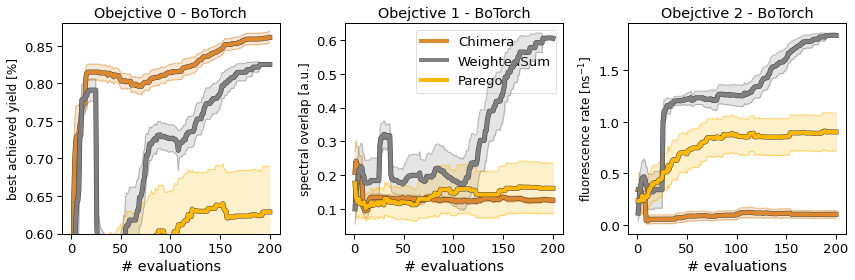

In [181]:
#--------
# BOTORCH 
#--------

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True)

for i in range(3):
    
    plot_trace_mean(traces_botorch['Chimera'], obj_num=i, ax=axes[i], color='#dd882c', label='Chimera')
    plot_trace_mean(traces_botorch['WeightedSum'], obj_num=i, ax=axes[i], color='gray', label='WeightedSum')
    plot_trace_mean(traces_botorch['Parego'], obj_num=i, ax=axes[i], color='#ffb703', label='Parego')

    #axes[i].set_yscale('log')
    axes[i].set_xlabel('# evaluations')
    axes[i].set_title(f'Obejctive {i} - BoTorch')

    
axes[1].legend(loc='upper right')

axes[0].set_ylim(0.6, 0.88)
axes[0].set_ylabel('peak score [a.u.]', fontsize=12)
axes[1].set_ylabel('spectral overlap [a.u.]', fontsize=12)
axes[2].set_ylabel('fluorescence rate [ns$^{-1}$]', fontsize=12)


axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()

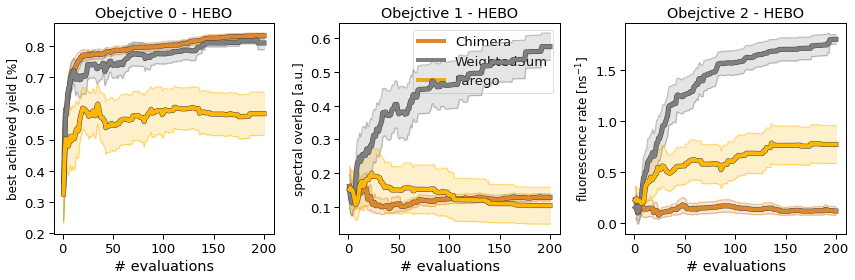

In [183]:
#------
# HEBO
#------

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True)

for i in range(3):
    
    plot_trace_mean(traces_hebo['Chimera'], obj_num=i, ax=axes[i], color='#dd882c', label='Chimera')
    plot_trace_mean(traces_hebo['WeightedSum'], obj_num=i, ax=axes[i], color='gray', label='WeightedSum')
    plot_trace_mean(traces_hebo['Parego'], obj_num=i, ax=axes[i], color='#ffb703', label='Parego')

    #axes[0].set_ylim(0.6, 0.88)
    #axes[i].set_yscale('log')
    axes[i].set_xlabel('# evaluations')
    axes[i].set_title(f'Obejctive {i} - HEBO')

    
axes[1].legend(loc='upper right')


axes[0].set_ylabel('peak score [a.u.]', fontsize=12)
axes[1].set_ylabel('spectral overlap [a.u.]', fontsize=12)
axes[2].set_ylabel('fluorescence rate [ns$^{-1}$]', fontsize=12)


axes[0].set_ylabel('best achieved yield [%]')
plt.tight_layout()